In [1]:
import nengo
import pytry
import numpy as np

model = nengo.Network()
period=0.75
off_time=0.65
n_presentations = 10

cue_period=1.0
cue_off_time=0.9
n_cue_presentations = 8

with model:
    def drug_func(t):
        if t%period < off_time:
            return 0
        else:
            return 1
    drug_intake = nengo.Node(drug_func)
    p_drug_presence = nengo.Probe(drug_intake)
    DA_activation = nengo.Ensemble(n_neurons=1000, dimensions=1)
    nengo.Connection(drug_intake, DA_activation)
    meso_sensitivity = nengo.Ensemble(n_neurons=1000, dimensions=1)
    p_meso=nengo.Probe(meso_sensitivity, synapse=0.01)
    nengo.Connection(DA_activation, meso_sensitivity, transform=0.1) 
    nengo.Connection(meso_sensitivity, meso_sensitivity,synapse =0.1, transform=0.95)
    
        ##### new #####
    def cue_func(t):
        if t%cue_period < cue_off_time:
            return 0
        else:
            return 1           
    stim = nengo.Node(cue_func)
    p_stim_presence = nengo.Probe(stim)
    
    cue_presence = nengo.Ensemble(n_neurons=1000, dimensions=1)
    p_cue = nengo.Probe(cue_presence)
    nengo.Connection(stim, cue_presence)

    cue_saliency = nengo.Ensemble(n_neurons=1000, dimensions=1)
    p_cue_saliency = nengo.Probe(cue_saliency, synapse = 0.01)

    def dopamine_func(t, x):
        error = x[0]
        if error >0:
            error = 0
        drug_rep = x[1]
        scale = np.interp(drug_rep, [0, 1], [1, 10])
        return error*scale
    dop_mod = nengo.Node(dopamine_func, size_in=2, size_out=1)
    error = nengo.Ensemble(n_neurons=1000, dimensions=1)
    p_ass = nengo.Probe(error)
    nengo.Connection(meso_sensitivity, dop_mod[1])
    nengo.Connection(error, dop_mod[0])
    
    c = nengo.Connection(cue_presence, cue_saliency, transform=0, 
                         learning_rule_type=nengo.PES(learning_rate=0.00001))
    nengo.Connection(cue_saliency, cue_saliency, synapse=0.1, transform=0.9)
    #nengo.Connection(cue_presence, cue_saliency, transform=0.1)
    #c = nengo.Connection(cue_saliency, cue_saliency, transform=0, 
                         #learning_rule_type=nengo.PES(learning_rate=0.00001))


    nengo.Connection(cue_presence, error,transform=-1)
    nengo.Connection(drug_intake, error)
    nengo.Connection(dop_mod, c.learning_rule)
    
    
    def structural_func(t, x):
        drug = x[1]
        cue = x[0]
        
        # map from (0,1) to (1, 10)
        size = np.interp(cue, [0, 1], [1.0, 10.0])
        
        return size * drug
    structural_mod = nengo.Node(structural_func, size_in=2, size_out=1)
    
    wanting = nengo.Ensemble(n_neurons=1000, dimensions=1)
    p_wanting = nengo.Probe(wanting, synapse = 0.01)
    nengo.Connection(cue_saliency, structural_mod[0], transform=0.1)
    nengo.Connection(meso_sensitivity, structural_mod[1])
    nengo.Connection(structural_mod, wanting)
            
sim = nengo.Simulator(model)
sim.run(10)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

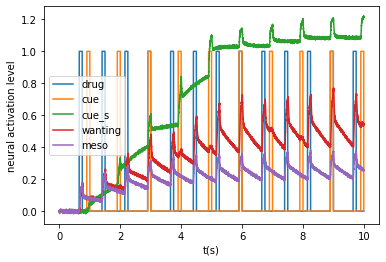

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(sim.trange(), sim.data[p_drug_presence], label = 'drug')
plt.plot(sim.trange(), sim.data[p_stim_presence], label = 'cue')
plt.plot(sim.trange(), sim.data[p_cue_saliency], label = 'cue_s')
plt.plot(sim.trange(), sim.data[p_wanting], label='wanting')
plt.plot(sim.trange(), sim.data[p_meso], label='meso')
#plt.plot(sim.trange(), sim.data[p_ass], label='asso')
plt.xlabel('t(s)')
plt.ylabel('neural activation level')

plt.legend();
